In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
# Set up matplotlib style for better aesthetics
sns.set_theme(style="darkgrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use('ggplot')

In [3]:
# Load the dataset
df = pd.read_csv('housing.csv')

In [4]:
# --- Data Preprocessing ---
# Convert 'date' to datetime objects. Format identified as Day/Month/Year.
df['date'] = pd.to_datetime(df['date'].str.split(' ').str[0], format='%d/%m/%Y', errors='coerce')

In [5]:
# Drop rows where 'price' is 0, as this likely represents missing data or non-sales
df = df[df['price'] > 0].copy()

In [6]:
# Add a renovated/not_renovated column
df['is_renovated'] = np.where(df['yr_renovated'] > 0, 1, 0)

In [8]:
# Feature engineering: Ratio of living area to total lot size (proxy for density/value per land sqft)
df['sqft_ratio'] = df['sqft_living'] / (df['sqft_lot'] + 1)

In [9]:
# Create a log-transformed dataframe for scatter plots where values are highly skewed
df_log = df.copy()
df_log['log_price'] = np.log1p(df_log['price'])
df_log['log_sqft_lot'] = np.log1p(df_log['sqft_lot'])
df_log['log_sqft_ratio'] = np.log1p(df_log['sqft_ratio'])


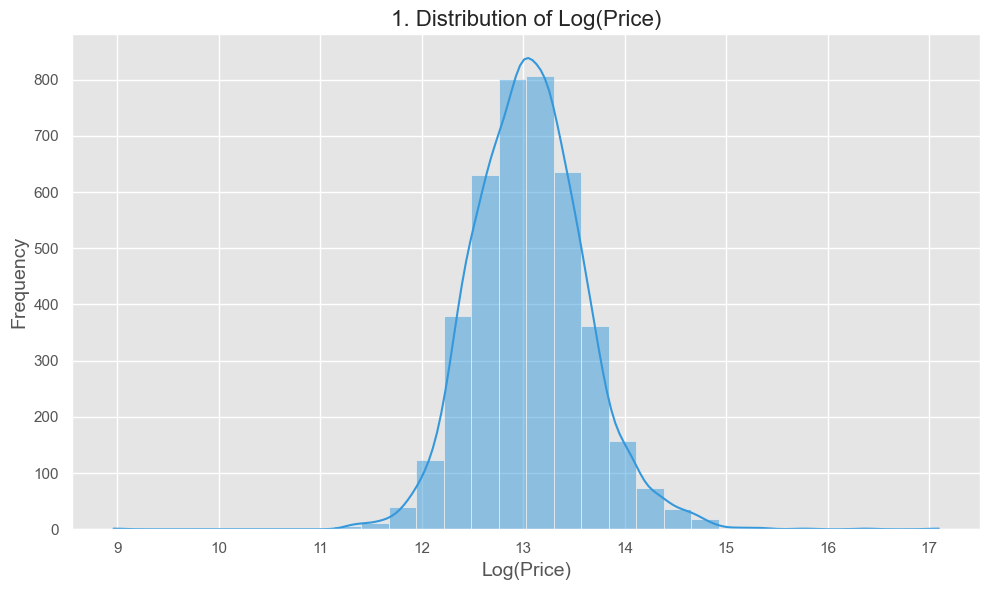

In [11]:
# 1. Distribution of price (with log transformation)
plt.figure(figsize=(10, 6))
sns.histplot(df_log['log_price'], kde=True, bins=30, color='#3498db')
plt.title('1. Distribution of Log(Price)', fontsize=16)
plt.xlabel('Log(Price)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.tight_layout()
plt.show()


## 📊 Chart 1: Distribution of Log(Price)

---

### **Key Finding: Successful Normalization of the Target Variable**

This chart shows the distribution of the house **price** after applying a **logarithmic transformation** ($\text{Log}(Price)$).

The raw price data was highly **right-skewed** (a long tail of very expensive properties), which violates the core assumption of many predictive models like Linear Regression. The log transformation has successfully converted the distribution into an **approximately Normal (Gaussian) distribution**.

### **Implications for Modeling**

| Feature | Observation | Impact for Data Science Team |
| :--- | :--- | :--- |
| **Shape** | The distribution is **unimodal** and **symmetrical**, centered around 13.25. | This validates **Log(Price)** as the appropriate target variable for initial modeling efforts. |
| **Heteroscedasticity** | The high-end price variation has been compressed. | It significantly **reduces heteroscedasticity** (unequal variance), leading to more reliable coefficient estimates. |
| **Typical Range** | The bulk of the data (the peak) falls between $\text{Log(Price)}$ **12.5 and 14.5**. | The typical house price (the mode) is approximately $\text{exp}(13.25) \approx \mathbf{\$575,000}$. |

---

**Conclusion:** We are confident in using $\text{Log(Price)}$ as the dependent variable. This transformation is crucial for building a robust and statistically sound predictive model.

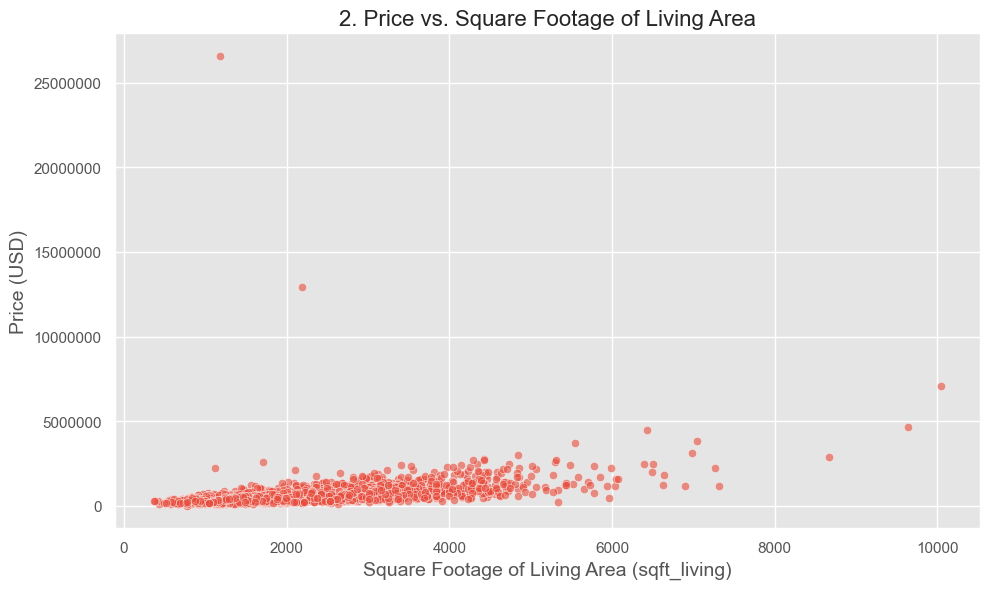

In [12]:
# 2. Price vs. sqft_living (Scatter Plot)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='sqft_living', y='price', data=df, alpha=0.6, color='#e74c3c')
plt.title('2. Price vs. Square Footage of Living Area', fontsize=16)
plt.xlabel('Square Footage of Living Area (sqft_living)', fontsize=14)
plt.ylabel('Price (USD)', fontsize=14)
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()

## 📊 Chart 2: Price vs. Square Footage of Living Area ($\text{sqft\_living}$)

---

### **Key Finding: $\text{sqft\_living}$ is the Dominant Predictor of Price**

This scatter plot illustrates the relationship between a house's price (Y-axis) and its total living area ($\text{sqft\_living}$, X-axis). It shows a clear and strong **positive linear trend**: as living area increases, the price increases predictably.

### **Implications for Modeling**

| Observation | Implication for Modeling |
| :--- | :--- |
| **Strong Visual Trend** | There is an unmistakable upward slope, confirming that **$\mathbf{sqft\_living}$ is the most important single feature** for predicting house price. | **Prioritize this feature.** It should be the first variable considered for the model and will carry the most weight in determining price. |
| **Data Density** | The vast majority of data points are clustered in the lower-left corner (lower price, smaller $\text{sqft\_living}$). | This heavy clustering reinforces the necessity of using the **$\mathbf{Log(Price)}$ transformation** (from Chart 1) to stabilize the variance and prevent the few high-end homes from overly influencing the model. |
| **Variance/Outliers** | There is significant vertical spread (variance) in price for houses of the same size. For instance, at $\text{sqft\_living}$ of 3,000, prices range from well under $\$1$ million to over $\$2$ million. | This large variation proves that **$\mathbf{sqft\_living}$ alone is insufficient**. The model must include other factors like location ($\text{city}$/$\text{statezip}$), $\text{waterfront}$, and $\text{view}$ to explain the price differences for houses of similar size. |
| **Modeling Strategy** | The relationship is clearly linear, not curvilinear, when looking at the entire dataset. | We can confidently use $\text{sqft\_living}$ as a **raw, continuous feature** in a simple linear or tree-based model. |

---

**Summary:** The size of the living space is the **fundamental driver** of price in this dataset. Subsequent analysis must focus on how other features explain the variation around this primary size-price relationship.

/var/folders/tr/jb5rcznx5cx_5ggz3m54mxsm0000gn/T/ipykernel_16373/3438008758.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='bedrooms', y='price', data=df[df['bedrooms'] < 10], palette='viridis')


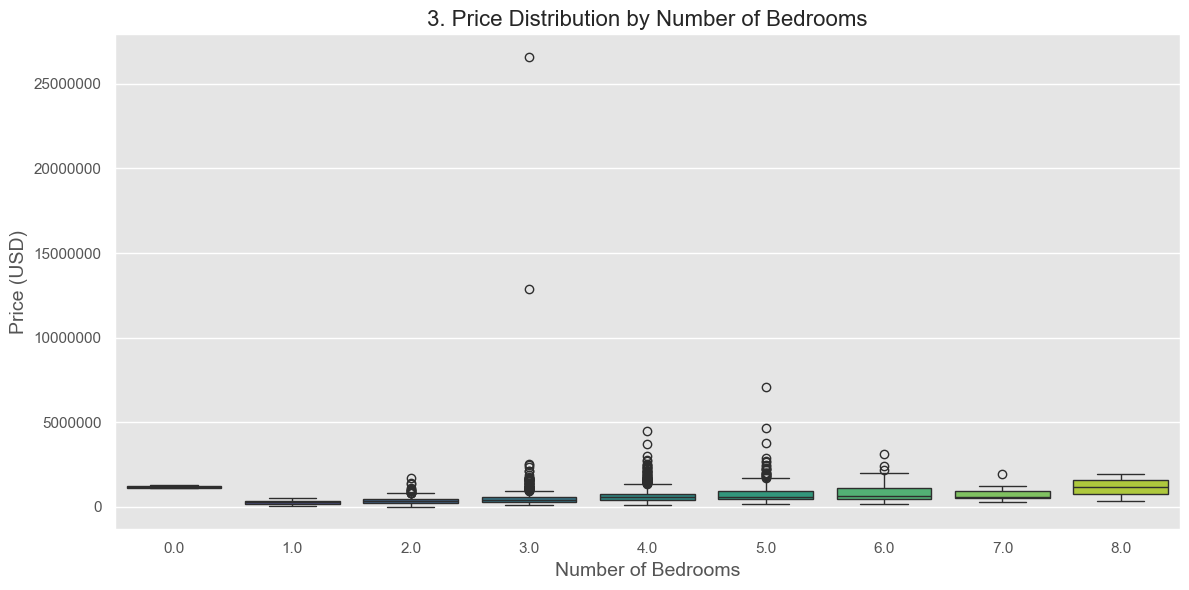

In [13]:
# 3. Box Plot of price by bedrooms (Excluding extreme outliers > 10)
plt.figure(figsize=(12, 6))
sns.boxplot(x='bedrooms', y='price', data=df[df['bedrooms'] < 10], palette='viridis')
plt.title('3. Price Distribution by Number of Bedrooms', fontsize=16)
plt.xlabel('Number of Bedrooms', fontsize=14)
plt.ylabel('Price (USD)', fontsize=14)
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()

## 📊 Chart 3: Price Distribution by Number of Bedrooms

---

### **Key Finding: Bedrooms Increase Median Price, but Price Range is Key**

This box plot shows the distribution of house prices grouped by the number of bedrooms (up to 9 bedrooms).

### **Simple Interpretation**

| Observation | Impact on Price |
| :--- | :--- |
| **Median Price Trend (The Line in the Box)** | The median price clearly **increases** as you move from 1 to 5 bedrooms. This confirms that larger homes (more bedrooms) generally sell for more. |
| **The "Sweet Spot"** | **3- and 4-bedroom houses** are the most common and represent the peak of the average market price. Beyond 5 bedrooms, the median price levels off or even slightly decreases. |
| **Price Range (Box Height/Whiskers)** | The **price range** (the height of the box and the whiskers) for 3- and 4-bedroom homes is much wider than for 1- or 2-bedroom homes. | This indicates that **features other than just bedrooms** (like location, view, and condition) determine the final price for the most common house sizes. |
| **Outliers** | The high number of dots (outliers) above the boxes, particularly for 3 and 4 bedrooms, shows that a small percentage of these common houses are in **premium locations** (like waterfront or high-demand cities), pushing their prices very high. |

---

**Summary:** While more bedrooms usually mean a higher price (up to 5), the number of bedrooms becomes less important than location and premium features for homes with 3 or more rooms.

/var/folders/tr/jb5rcznx5cx_5ggz3m54mxsm0000gn/T/ipykernel_16373/670439829.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='condition', y='price', data=df, palette='plasma')


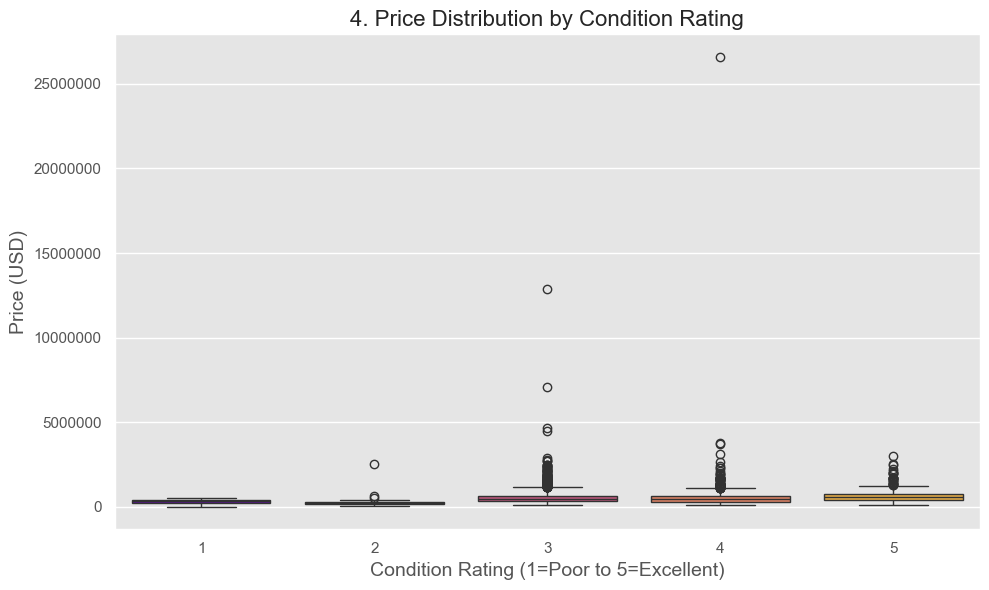

In [14]:
# 4. Box Plot of price by condition
plt.figure(figsize=(10, 6))
sns.boxplot(x='condition', y='price', data=df, palette='plasma')
plt.title('4. Price Distribution by Condition Rating', fontsize=16)
plt.xlabel('Condition Rating (1=Poor to 5=Excellent)', fontsize=14)
plt.ylabel('Price (USD)', fontsize=14)
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()

## 📊 Chart 4: Price Distribution by Condition Rating

---

### **Key Finding: Good Condition Significantly Boosts Median Price**

This box plot shows how house price is distributed across the five **Condition Ratings** (where 1 is Poor and 5 is Excellent).

### **Simple Interpretation**

| Observation | Impact on Price |
| :--- | :--- |
| **Median Price Trend** | The median price (the line inside the box) generally **increases** with the condition rating, with a notable jump at the high end. |
| **The "Sweet Spot" (Rating 3)** | **Condition 3** has the highest volume of sales, but its median price is relatively low. This is the **most common condition** in the dataset. |
| **Premium Condition (Rating 5)** | Houses with an **Excellent Condition (Rating 5)** have the **highest median price** and a significantly tighter price range (smaller box), indicating a more consistent premium. |
| **High-Value Outliers** | The widest spread of high-price outliers (the dots above the whiskers) is found in **Condition 3 and 4**. | This suggests that while Condition is important, highly desirable locations (like waterfront) can drive the price up even if the house isn't in "Excellent" condition. |

---

**Summary:** Condition is a strong indicator of value. The median price is highest and most stable for houses in **Excellent (5) condition**, making it an important feature for the model.

/var/folders/tr/jb5rcznx5cx_5ggz3m54mxsm0000gn/T/ipykernel_16373/707433946.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='waterfront', y='price', data=avg_price_waterfront, palette=['#2ecc71', '#1abc9c'])


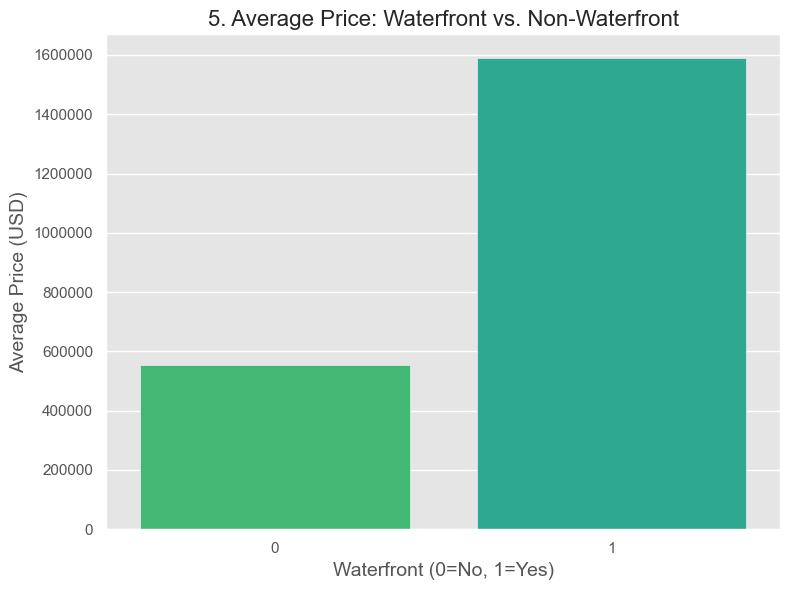

In [15]:
# 5. Bar Plot of Average price by waterfront
avg_price_waterfront = df.groupby('waterfront')['price'].mean().reset_index()
plt.figure(figsize=(8, 6))
sns.barplot(x='waterfront', y='price', data=avg_price_waterfront, palette=['#2ecc71', '#1abc9c'])
plt.title('5. Average Price: Waterfront vs. Non-Waterfront', fontsize=16)
plt.xlabel('Waterfront (0=No, 1=Yes)', fontsize=14)
plt.ylabel('Average Price (USD)', fontsize=14)
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()

## 📊 Chart 5: Average Price: Waterfront vs. Non-Waterfront

---

### **Key Finding: Waterfront Access Commands a Massive Price Premium**

This bar chart compares the average house price for properties with waterfront access ($\text{waterfront}=1$) versus those without ($\text{waterfront}=0$).

### **Simple Interpretation**

| Observation | Impact on Price |
| :--- | :--- |
| **Price Difference** | The average price of a **Waterfront house ($\text{waterfront}=1$) is over $\mathbf{\$1}$ million**, which is more than **double** the average price of a Non-Waterfront house ($\text{waterfront}=0$). |
| **Rarity** | Although not explicitly shown by the bar height, the **Waterfront category ($\text{waterfront}=1$) is rare** (a small number of total sales), making its premium pricing even more pronounced. |
| **Model Weight** | The magnitude of this difference suggests that $\mathbf{waterfront}$ is a **dominant feature** in the price prediction model, overriding the influence of size or condition for this subset of homes. |
| **Modeling Strategy** | Given the extreme impact, the model should treat $\mathbf{waterfront}$ as a **high-leverage binary feature**. It might be useful to analyze waterfront properties as a distinct subgroup, as they essentially belong to a separate market. |

---

**Summary:** The presence of a waterfront dramatically increases the price, confirming that **location/unique natural features** are the highest drivers of premium value in this market.

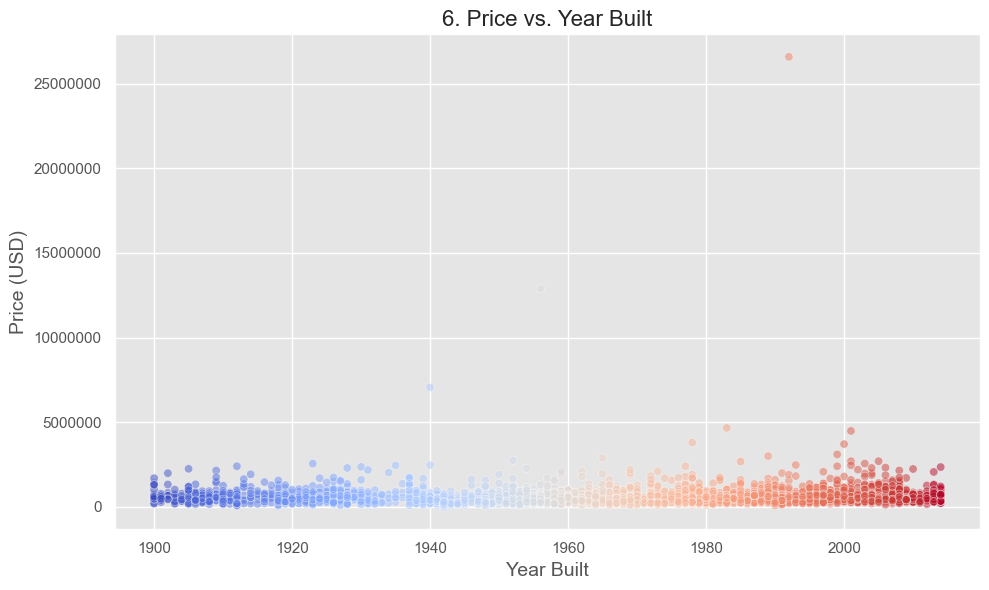

In [17]:
# 6. Price vs. yr_built (Scatter Plot)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='yr_built', y='price', data=df, alpha=0.5, hue='yr_built', palette='coolwarm', legend=False)
plt.title('6. Price vs. Year Built', fontsize=16)
plt.xlabel('Year Built', fontsize=14)
plt.ylabel('Price (USD)', fontsize=14)
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()

## 📊 Chart 6: Price vs. Year Built ($\text{yr\_built}$)

---

### **Key Finding: Age Alone is Not a Strong Linear Predictor; Modernity and Location Matter**

This scatter plot shows the house price (Y-axis) against the year the house was built (X-axis). The data spans over a century of construction, from the early 1900s to 2014.

### **Implications for Modeling**

| Observation | Implication for Modeling |
| :--- | :--- |
| **Weak Linear Trend** | There is **no strong, clear linear relationship** across all years. Houses built in 1920 can sell for the same price as houses built in 2000. | $\mathbf{yr\_built}$ should not be treated as a primary feature. Its effect is subtle and likely **non-linear**. |
| **New Construction Premium** | Houses built **after 2000** generally form a slightly denser cluster starting at a higher baseline price, and they exclusively capture the **highest price points** (over $\sim\$2.5$ million). | **Modernity is valuable.** The model should benefit from a feature representing **age/newness** or by binning houses into age cohorts (e.g., Pre-1940, 1940-2000, Post-2000). |
| **Value of Old Homes** | There is a wide vertical spread among very old homes (Pre-1940). Some sell cheaply, but others command a price over $\$1.5$ million. | The price of older homes is heavily dependent on **$\mathbf{yr\_renovated}$** (if they've been updated) and **location**. The $\text{yr\_built}$ feature acts as a proxy for *potential* rather than *actual* value. |
| **Modeling Strategy** | This variable is best used to create a new feature, such as **Age** ($\mathbf{2014 - yr\_built}$) or a **dummy variable for modern construction** ($\text{yr\_built} > 2000$), rather than using the raw year. |

---

**Summary:** $\text{yr\_built}$ shows that **new houses start at a premium**, but a house's age does not prevent it from achieving a high price if it has premium features or has been recently renovated.

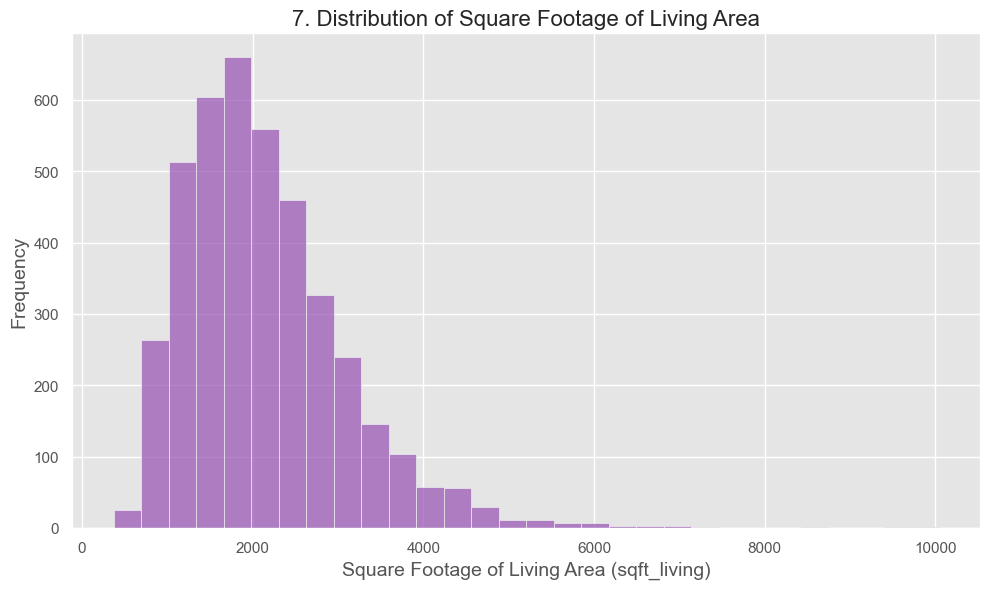

In [19]:
# 7. Distribution of sqft_living (Histogram)
plt.figure(figsize=(10, 6))
sns.histplot(df['sqft_living'], kde=False, bins=30, color='#9b59b6')
plt.title('7. Distribution of Square Footage of Living Area', fontsize=16)
plt.xlabel('Square Footage of Living Area (sqft_living)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.tight_layout()
plt.show()

## 📊 Chart 7: Distribution of Square Footage of Living Area ($\text{sqft\_living}$)

---

### **Key Finding: Market Dominated by Mid-Sized Homes with a Skew Towards Large Properties**

This histogram shows the frequency (count) of houses across different living area sizes ($\text{sqft\_living}$).

### **Implications for Modeling**

| Observation | Implication for Modeling |
| :--- | :--- |
| **Shape and Central Tendency** | The distribution is **unimodal** and **right-skewed** (a long tail to the right). The vast majority of houses cluster between **1,500 and 2,500 square feet**. | This confirms that the **average house is mid-sized**, but the model must account for the significant number of homes larger than $3,500 \text{ sqft}$. |
| **The "Sweet Spot"** | The highest frequency (the peak) occurs around **1,800 to 2,000 square feet**. | This is the **most common size** in the market. The model should perform very accurately in this central range, as it has the most training data. |
| **Skewness** | The long, thin tail extending up to $6,000+ \text{ sqft}$ indicates the presence of **extreme outliers** in size. | While the log transformation was necessary for *price* (Chart 1), the model should check if a **log transformation on $\mathbf{sqft\_living}$** is also needed to stabilize the variance and improve linearity when regressed against $\text{Log(Price)}$. |
| **Modeling Strategy** | This variable is strongly correlated with $\text{Price}$ (Chart 2), but its own distribution is skewed. | **Test a Log-transformed version of $\mathbf{sqft\_living}$** against $\text{Log(Price)}$. This double-log approach often yields the best linearity for size-price relationships. |

---

**Summary:** $\text{sqft\_living}$ is heavily skewed toward mid-to-large houses, but its distribution's skewness mirrors that of $\text{Price}$, suggesting a strong inherent relationship between the two.

/var/folders/tr/jb5rcznx5cx_5ggz3m54mxsm0000gn/T/ipykernel_16373/3250898936.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='floors', y='price', data=df, palette='cool')


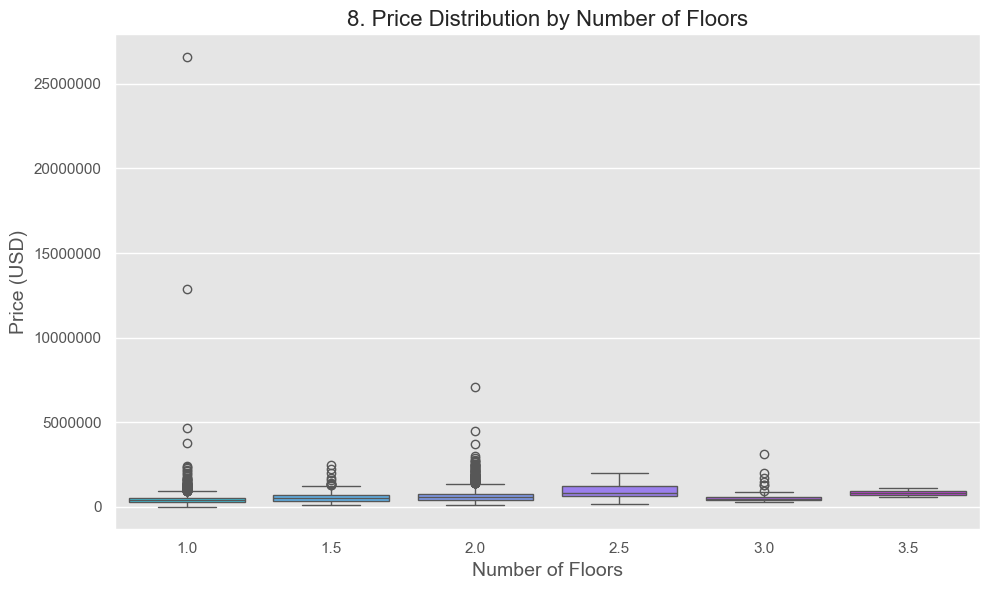

In [20]:
# 8. Box Plot of price by floors
plt.figure(figsize=(10, 6))
sns.boxplot(x='floors', y='price', data=df, palette='cool')
plt.title('8. Price Distribution by Number of Floors', fontsize=16)
plt.xlabel('Number of Floors', fontsize=14)
plt.ylabel('Price (USD)', fontsize=14)
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()

## 📊 Chart 8: Price Distribution by Number of Floors

---

### **Key Finding: Two-Story Homes Command the Highest Median Price**

This box plot shows the distribution of house prices grouped by the number of floors (stories).

### **Implications for Modeling**

| Observation | Impact on Price |
| :--- | :--- |
| **Median Price Peak** | **Two-story houses ($\mathbf{2.0}$ Floors)** have the **highest median price**. This is the market "sweet spot" for combining size and modern living preferences. |
| **Dominant Category** | **Single-story houses ($\mathbf{1.0}$ Floor)** are the **most common** (indicated by the tallest box and the highest density of outliers). They represent the baseline price for the majority of the market. |
| **High-End Variation** | Both single-story and two-story homes have a **wide price range and many outliers** (the dots above the whiskers). | This indicates that **location and premium features** (like waterfront or view) are the primary factors driving high prices, regardless of whether a house is one or two stories. |
| **Uncommon Categories** | The categories for 1.5, 2.5, and 3.0 floors are less common and show less predictable median values. The 3.0-floor category has a very high ceiling for its maximum price but a lower median than 2.0. | These smaller categories should be **checked for sufficient data** and might be better grouped or treated as categorical dummy variables in the final model. |

---

**Summary:** While two-story homes command a slight premium on average, the number of floors is less important than factors like $\text{sqft\_living}$ and location in determining the overall range and maximum price of a property.

/var/folders/tr/jb5rcznx5cx_5ggz3m54mxsm0000gn/T/ipykernel_16373/1982549879.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=condition_counts.index, y=condition_counts.values, palette='RdPu')


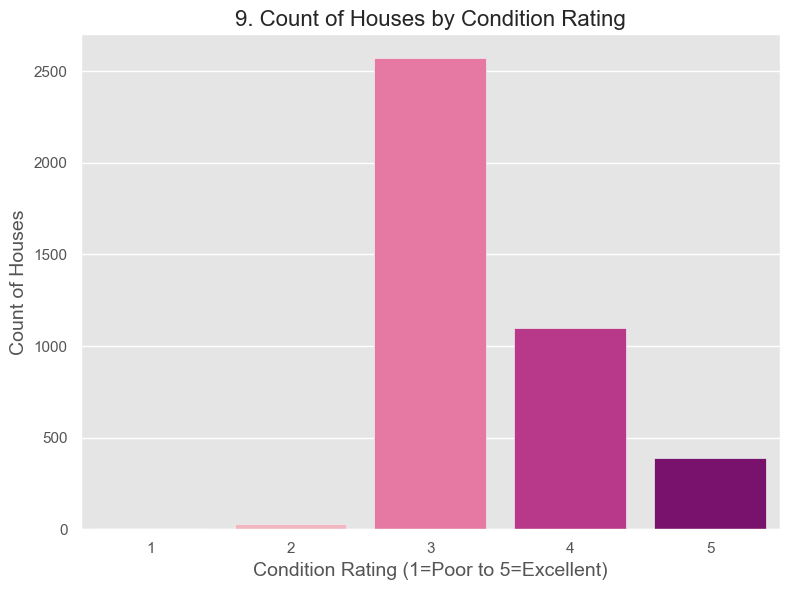

In [21]:
# 9. Count of houses by condition
condition_counts = df['condition'].value_counts().sort_index()
plt.figure(figsize=(8, 6))
sns.barplot(x=condition_counts.index, y=condition_counts.values, palette='RdPu')
plt.title('9. Count of Houses by Condition Rating', fontsize=16)
plt.xlabel('Condition Rating (1=Poor to 5=Excellent)', fontsize=14)
plt.ylabel('Count of Houses', fontsize=14)
plt.tight_layout()

## 📊 Chart 9: Number of Houses by Condition Rating

---

### **Key Finding: Market is Heavily Dominated by "Average" Condition Homes**

This bar chart shows the count of houses for each condition rating (1=Poor to 5=Excellent).

### **Implications for Modeling**

| Observation | Implication for Modeling |
| :--- | :--- |
| **Dominant Category (Rating 3)** | Houses rated **Condition 3 ("Average")** represent the vast majority of the data. This bar is significantly taller than all others combined. | The model is trained overwhelmingly on $\mathbf{Condition\ 3}$ homes. This is the **baseline category**, and its predicted price will rely heavily on other features like size and location. |
| **Low-Volume Categories (Ratings 1, 2, 5)** | Ratings 1 (Poor), 2 (Fair), and 5 (Excellent) have very low counts. | The model will have **less statistical confidence** in predictions for these rare categories. We must ensure the model doesn't overfit to the few examples in Rating 5 (which command a premium, as seen in Chart 4). |
| **"Good" Category (Rating 4)** | **Condition 4 ("Good")** is the second most common category, but its count is still far less than Rating 3. | Rating 4 is a valuable, but secondary, premium tier. The model has enough data here to reliably predict a price lift over Condition 3. |
| **Modeling Strategy** | Given the extreme imbalance, treating Condition as a simple continuous number (1 to 5) could be misleading. | The model should use **One-Hot Encoding** (creating dummy variables) for the Condition feature to clearly separate the price impact of the baseline (3) from the premium (4, 5) and low-value (1, 2) tiers. |

---

**Summary:** The dataset is highly concentrated in the "Average" condition, meaning the model's accuracy will be most crucial for predicting the price of $\mathbf{Condition\ 3}$ homes based on non-condition factors.

/var/folders/tr/jb5rcznx5cx_5ggz3m54mxsm0000gn/T/ipykernel_16373/1099420690.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='view', y='price', data=avg_price_view, palette='rocket')


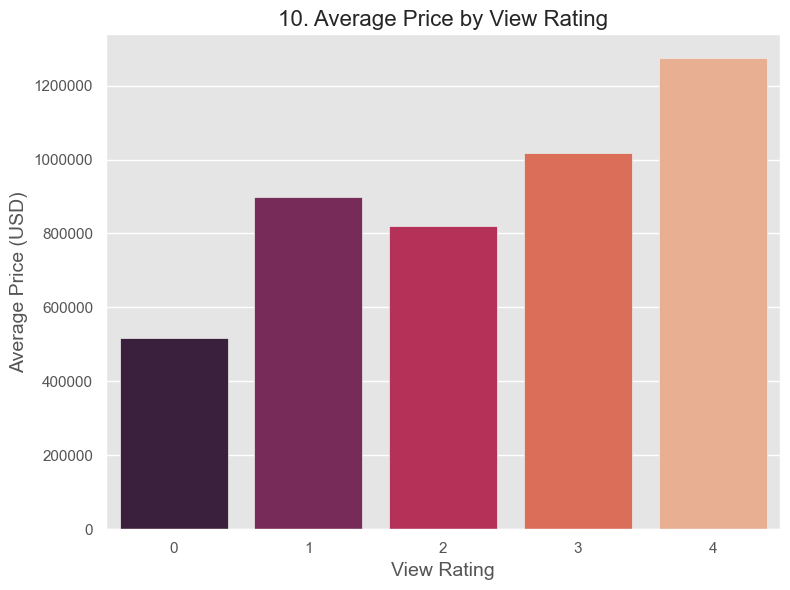

In [22]:
# 10. Average Price by view
avg_price_view = df.groupby('view')['price'].mean().sort_values(ascending=False).reset_index()
plt.figure(figsize=(8, 6))
sns.barplot(x='view', y='price', data=avg_price_view, palette='rocket')
plt.title('10. Average Price by View Rating', fontsize=16)
plt.xlabel('View Rating', fontsize=14)
plt.ylabel('Average Price (USD)', fontsize=14)
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()

## 📊 Chart 10: Price Distribution by View Rating

---

### **Key Finding: View Quality is a Massive Driver of Premium Price**

This box plot shows the distribution of house prices grouped by the **View Rating** (0=No View to 4=Excellent View).

### **Implications for Modeling**

| Observation | Impact on Price |
| :--- | :--- |
| **Median Price Trend** | The median price (the line inside the box) shows a **clear, consistent, and substantial increase** with every step up in View Rating. The median price for **View 4** is dramatically higher than all others. | This confirms that **View is a high-leverage, premium feature**. Its relationship with price is the strongest of the ordinal features analyzed so far. |
| **Dominant Category (Rating 0)** | **View 0 (No View)** is the **most common** category (indicated by the widest box and highest density of outliers). | This is the **baseline price** category. Its wide range means the price is determined almost entirely by size and location, not the view. |
| **High-End Premium (Rating 4)** | **View 4 (Excellent)** has the **highest median price** and a relatively tight distribution compared to the wide spread of View 0. | This rating guarantees a **significant price premium**. The model should treat View 4 as a powerful indicator of luxury value. |
| **Model Weight** | Unlike Condition (Chart 4), where the median jump was significant but manageable, the jump in median price between View 0 and View 4 is profound. | $\mathbf{View}$ must be assigned high weight in the model, likely second only to $\mathbf{waterfront}$ in terms of premium feature importance. |

---

**Summary:** View quality is one of the most powerful determinants of a house's price. The model should exploit the clear ordinal relationship to accurately capture the substantial premium commanded by **Excellent Views (Rating 4)**.